In [1]:
import os, gc
import sys, pdb
import copy, time
import json, random
import time

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path

import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
from colorama import Style, Fore
%matplotlib inline

In [2]:

import signal
import psutil
import itertools
import subprocess
import base64, gzip
import networkx as nx
import multiprocessing
#::::::::::::::::::::::::::::::::::::::::::::::
from numpy import array
from pathlib import Path
from scipy import ndimage
from scipy.stats import mode
from tqdm.auto import trange
from functools import partial
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
from xgboost import XGBClassifier
from itertools import combinations, product
from collections import defaultdict, Counter
from skimage.measure import label, regionprops
#::::::::::::::::::::::::::::::::::::::::::::::
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from skimage.measure import label, regionprops
from sklearn.preprocessing import MinMaxScaler

from subprocess import Popen, PIPE, STDOUT
from glob import glob

In [3]:
from solver_7 import predict_repeating, check_sub_grid_2x, check_repeating, check_grid, predict_transforms_grid_2x, \
    check_chess, predict_chess, grid_filter, check_tiles_shape, predict_tiles_shape, check_grid_transforms, predict_grid_transforms, \
        check_sub_mask, predict_repeating_mask, check_subitem
from tree import format_features, make_features, tree1
from color_counter import Create, colors_counter
from sym_repairing import symmetry_repairing

^C


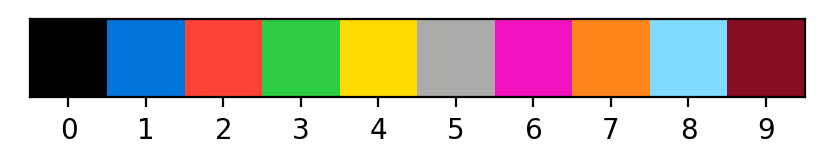

In [5]:
train1_path = '../input/arc-prize-2024/arc-agi_training_challenges.json'
train2_path = '../input/arc-prize-2024/arc-agi_training_solutions.json'

eval1_path = '../input/arc-prize-2024/arc-agi_evaluation_challenges.json'
eval2_path = '../input/arc-prize-2024/arc-agi_evaluation_solutions.json'

test_path = '../input/arc-prize-2024/arc-agi_test_challenges.json'
sample_path = '../input/arc-prize-2024/sample_submission.json'

# ......................................................................................................
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

# ......................................................................................................
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

In [6]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_data(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=200)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in = np.array(t["input"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()  
    
# ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


# <span style="color:darkred;">Run Solvers</span>

<p style="border-bottom: 15px solid darkcyan"></p>
<p style="border-bottom: 5px solid darkred"></p>

In [7]:
# ..................................................................................... 1
def ganswer_answer(ganswer):
    
    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j].tolist()
        
        if (ganswer_j not in answer):  
            answer.append(ganswer_j)   
            
    return answer

# ..................................................................................... 2
def ganswer_answer_1(ganswer):
    
    answer = []
    for j in range(len(ganswer)):
        ganswer_j = ganswer[j]
        
        if (ganswer_j not in answer):  
            answer.append(ganswer_j)   
            
    return answer

# ..................................................................................... 3
def prn_plus(prn, answer):
    
    for j in range(len(answer)):
        prn = prn + [answer[j]]  
        
        if (j == 0):
            prn = prn + [answer[j]]
            
    return prn

# ..................................................................................... 4
def prn_select_2(prn): 
    if (len(prn) > 2):
        
        value_list = []
        string_list = []
        for el in prn:
            value = 0
            for i in range(len(prn)):
                if el == prn[i]:
                    value +=1
            value_list.append(value)
            string_list.append(str(el))    
        
        prn_df  = pd.DataFrame({'prn': prn , 'value': value_list, 'string': string_list}) 
        prn_df1 = prn_df.drop_duplicates(subset=['string'])
        prn_df2 = prn_df1.sort_values(by='value', ascending=False)   
        
        prn = prn_df2['prn'].values.tolist()[:2]
        
    return prn

# ..................................................................................... 5
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])

norm = colors.Normalize(vmin=0, vmax=9)
color_list = ["black", "blue", "red", "green", "yellow", "gray", "magenta", "orange", "sky", "brown"]

def plot_pic(x):
    plt.imshow(np.array(x), cmap=cmap, norm=norm)
    plt.show()
    

TypeError: Invalid shape () for image data

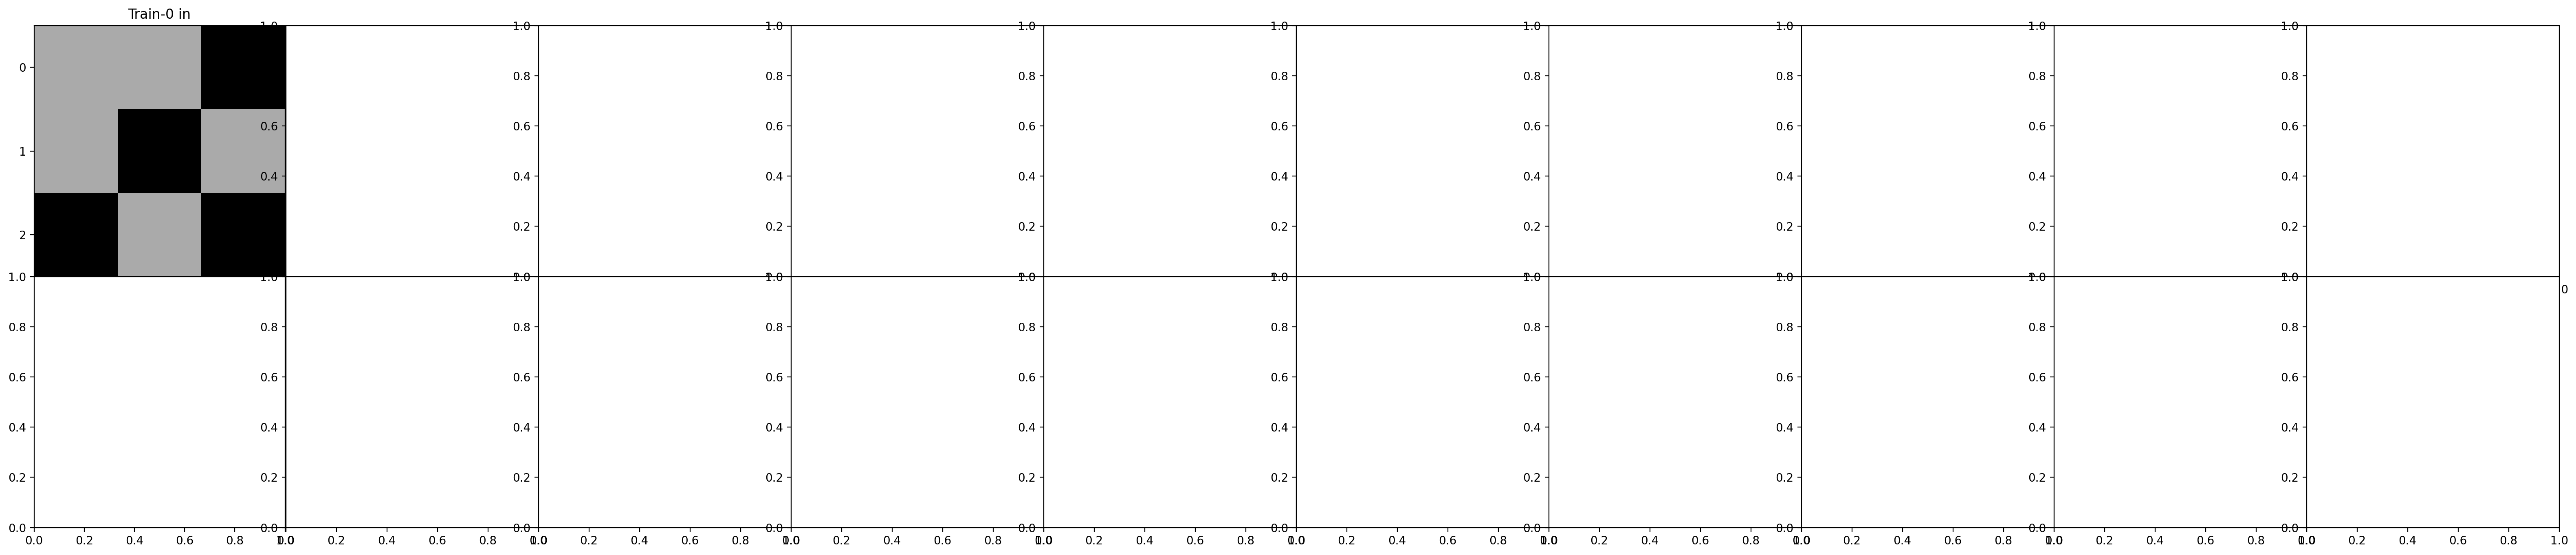

In [12]:
def run_main_solvers(data_path, sample_path): 

    with open(sample_path,'r') as f:
        sub_solver = json.load(f) 
        
    with open('/kaggle/working/sub_icecube.json' , 'r') as f:
        sub_icecube = json.load(f)

    # ...............................................................................
    with open(data_path,'r') as f:
        tasks_name = list(json.load(f).keys())
    
    with open(data_path,'r') as f:
        tasks_file = list(json.load(f).values())
        
    # ...............................................................................
    for n in range(len(tasks_name)):
        task = tasks_file[n]
        t = tasks_name[n]
        # if t != "27a28665":
        #     continue
        
        for i in range(len(task['test'])): 
            test_input = np.array(task['test'][i]['input'])
            prn = []
                
            # ............................................................................... 1 - Different Solvers       
            if check_repeating(task, True): 
                
                filtered_idx_set = set()
                for j in range(len(task['train'])): 
                    
                    train_input = np.array(task['train'][j]['input'])
                    train_output = np.array(task['train'][j]['output'])
                    ganswer = predict_repeating(train_input)
                    
                    if (ganswer!= []):
                        answer = ganswer_answer(ganswer)
                        prn = prn_plus(prn, answer) 
                        
                        for prn_idx in range(len(prn)):
                            if np.all(prn[prn_idx] == train_output):
                                filtered_idx_set.add(prn_idx)
                    prn = []
                ganswer = predict_repeating(test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
                    filtered_prn = []
                    for filtered_idx in filtered_idx_set:
                        if filtered_idx < len(prn):
                            filtered_prn.append(prn[filtered_idx])
                            
                uniques = []
                for arr in filtered_prn:
                    if not any(np.array_equal(arr, unique_arr) for unique_arr in uniques):
                        uniques.append(arr)
                prn = uniques
                        
            # ________________________________________________________
            if check_grid(task) and check_sub_grid_2x(task): 
                ganswer = predict_transforms_grid_2x(task, test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
         
            # ________________________________________________________
            if check_grid(task) and check_chess(task, False, True): 
                ganswer = predict_chess(grid_filter(test_input))
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
                     
            # ________________________________________________________
            if check_tiles_shape(task, True): 
                ganswer = predict_tiles_shape(task, test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
            
            # ________________________________________________________
            if check_grid(task) and check_grid_transforms(task): 
                ganswer = predict_grid_transforms(task, test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
            
            # ________________________________________________________
            if check_sub_mask(task): 
                ganswer = predict_repeating_mask(test_input)
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
            
                
  
            # ............................................................................... 2 - Sklearn tree          
            if check_subitem(task):
                train_t = format_features(task)
                print(task)
                test_t = make_features(test_input) 
                ganswer = tree1(train_t, test_t, test_input)  
                
                if (ganswer!= []):
                    answer = ganswer_answer(ganswer)
                    prn = prn_plus(prn, answer) 
                

            # ............................................................................... 3 - Symmetry Repairing       
            basic_task = Create(task, i) 
            ganswer = symmetry_repairing(basic_task)   
        
            if (ganswer != -1):
                answer = ganswer_answer_1(ganswer)
                prn = prn_plus(prn, answer) 
     
            # ............................................................................... 4 - Colors Counter
            basic_task = Create(task, i) 
            answer = colors_counter(basic_task)   
            
            if (answer != -1):
                answer = [answer]
                prn = prn_plus(prn, answer) 

            # ...............................................................................  Conclusion
            if (prn != []):  
                prn = prn_select_2(prn)
                
                sub_solver[t][i]['attempt_1'] = prn[0]
                display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'1', 'Files':'test_challenges'},index=[n]))
                # plot_pic(prn[0])
                
                if (len(prn)==2):
                    sub_solver[t][i]['attempt_2'] = prn[1]
                    display(pd.DataFrame(data={'Answers for task':t, 'Items':i, 'Attempt':'2', 'Files':'test_challenges'},index=[n]))
                    # plot_pic(prn[1])

            # ............................................................................... 5 - ICECube
            if (sub_solver[t][i]['attempt_1'] != [[0, 0], [0, 0]]):     
                if (sub_icecube[t][i]['attempt_1'] != [[0, 0], [0, 0]]):
                    
                    if (sub_solver[t][i]['attempt_1'] != sub_icecube[t][i]['attempt_1']):
                        sub_solver[t][i]['attempt_2'] =  sub_icecube[t][i]['attempt_1']
                    
            if (sub_solver[t][i]['attempt_1'] == [[0, 0], [0, 0]]):
                if (sub_solver[t][i]['attempt_2'] == [[0, 0], [0, 0]]):
                    
                    if (sub_icecube[t][i]['attempt_1'] != [[0, 0], [0, 0]]):
                        sub_solver[t][i]['attempt_1'] = sub_icecube[t][i]['attempt_1']  
                        
                    if (sub_icecube[t][i]['attempt_2'] != [[0, 0], [0, 0]]):
                        sub_solver[t][i]['attempt_2'] = sub_icecube[t][i]['attempt_2']                
                    
            plot_task(task)
            # plot_pic(sub_solver[t][i]['attempt_1'])
            # plot_pic(sub_solver[t][i]['attempt_2'])
            
    ## ............................................................................... 
    ## display(sub_solver)    
    return sub_solver

# ...............................................................................    
sub_solver = run_main_solvers(train1_path, sample_path)
# sub_solver = run_main_solvers(test_path, sample_path)

# with open('submission.json', 'w') as file:
#     json.dump(sub_solver, file, indent=4)